In [24]:
#Extra stuff imported, I will keep it like this for testing 
import os
import re
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
#Folder Structure
DATA_DIR = "C:/Users/franc/Desktop/MSP/26_PRO3000/images/44_80"

print("Body_Movements_Train")
for folder_name in sorted(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(folder_path):
        png_count = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        print(f"├── {folder_name} [{png_count} .png files]")

#The "nothing" class is removed, because it was very small class around 90 images 
#and mostly containing no real features that can be learned by the model, mostly pure noise 

Body_Movements_Train
├── Box_Ana [33 .png files]
├── Box_Enrique [52 .png files]
├── Box_Fran [33 .png files]
├── Box_Mero [52 .png files]
├── Jump_Enrique [18 .png files]
├── Jump_Fran [15 .png files]
├── Jump_Mero [21 .png files]
├── Jump_Sam [13 .png files]
├── Nothing [86 .png files]
├── Sam_Box [52 .png files]
├── Spin_Enrique [15 .png files]
├── Spin_Fran [32 .png files]
├── Spin_Mero [17 .png files]
├── Spin_Sam [16 .png files]
├── Walking_Ana [51 .png files]
├── Walking_Enrique [52 .png files]
├── Walking_Fran [52 .png files]
├── Walking_Mero [52 .png files]
├── Walking_Sam [52 .png files]


In [26]:
# Define the base path to your images
# this path should have folders containing training images

base_path = 'C:/Users/franc/Desktop/MSP/26_PRO3000/images/44_80/'

# Check if the base path exists
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base path does not exist: {base_path}")

# Remove hidden files (e.g., .DS_Store, ., ..)
def remove_hidden_files(base_path):
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.startswith('.'):  # Exclude hidden files
                file_path = os.path.join(root, file)
                print(f"Removing hidden file: {file_path}")
                os.remove(file_path)

remove_hidden_files(base_path)

# # Shuffle the files in the training dataset directory
# def shuffle_training_files(base_path):
#     for class_folder in os.listdir(base_path):
#         class_path = os.path.join(base_path, class_folder)
#         if os.path.isdir(class_path):
#             files = os.listdir(class_path)
#             random.shuffle(files)  # Randomize file order
#             for i, file in enumerate(files):
#                 old_path = os.path.join(class_path, file)
#                 new_path = os.path.join(class_path, f"{i:06d}_{file}")  # Rename files to maintain order
#                 os.rename(old_path, new_path)

# shuffle_training_files(base_path)

When it comes to image sizes, the previous team use the flipped height and width. That is pretty bad for the model, it was able to learn features from a perspective that was different than the actual spectograms. 
Moreover the model was trained on both channels images, and the folder structure only had 2 categories in total. 

Now we set clear folder structure and proper image shape for the input. 

I recreated the script to generate the splits
!Checkout the Split_Script is easier to use now with clear indications. 

 (it will work properly now, after the updates some syntax feature deprecated and because of lack of comments and indications in the previous code, I was not able to use their confusion matrix code, but we have new code for that no worries.)

In [27]:
# Parameters
IMG_SIZE = (800,256)  # initially was (64, 1000)
BATCH_SIZE = 32
RANDOM_STATE = 42

# Data Preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Load train and validation sets (90% for training, 10% for validation)
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    seed=RANDOM_STATE
)

validation_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True,
    seed=RANDOM_STATE
)

test_generator = train_datagen.flow_from_directory(
    directory=base_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

#Visualize this 
print("Train classes:", train_generator.class_indices)
print("Validation samples:", validation_generator.samples)


#There is an automatic data split with the .py script "Split_Script", this data should be the one that is used for training 
#The rest is for validation and training

for class_folder in os.listdir(base_path):
    folder = os.path.join(base_path, class_folder)
    if os.path.isdir(folder):
        print(f"{class_folder}: {len(os.listdir(folder))} images")


Found 649 images belonging to 19 classes.
Found 65 images belonging to 19 classes.
Found 714 images belonging to 19 classes.
Train classes: {'Box_Ana': 0, 'Box_Enrique': 1, 'Box_Fran': 2, 'Box_Mero': 3, 'Jump_Enrique': 4, 'Jump_Fran': 5, 'Jump_Mero': 6, 'Jump_Sam': 7, 'Nothing': 8, 'Sam_Box': 9, 'Spin_Enrique': 10, 'Spin_Fran': 11, 'Spin_Mero': 12, 'Spin_Sam': 13, 'Walking_Ana': 14, 'Walking_Enrique': 15, 'Walking_Fran': 16, 'Walking_Mero': 17, 'Walking_Sam': 18}
Validation samples: 65
Box_Ana: 33 images
Box_Enrique: 52 images
Box_Fran: 33 images
Box_Mero: 52 images
Jump_Enrique: 18 images
Jump_Fran: 15 images
Jump_Mero: 21 images
Jump_Sam: 13 images
Nothing: 86 images
Sam_Box: 52 images
Spin_Enrique: 15 images
Spin_Fran: 32 images
Spin_Mero: 17 images
Spin_Sam: 16 images
Walking_Ana: 51 images
Walking_Enrique: 52 images
Walking_Fran: 52 images
Walking_Mero: 52 images
Walking_Sam: 52 images


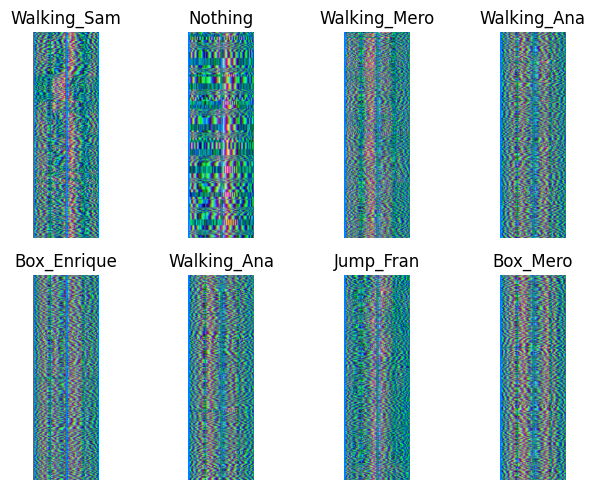

In [28]:
# Visualize some images 

# Get a batch of images and labels
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

# Plot settings
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))

for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    ax.set_title(f"{true_label}")

plt.tight_layout()
plt.show()

In [ ]:
# Build the CNN model

def make_model():

    Classifier = Sequential()
    Classifier.add(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    #Block 1 
    Classifier.add(Conv2D(32, (5, 64)))
    Classifier.add(LeakyReLU(alpha=0.1))
    Classifier.add(MaxPooling2D(pool_size=(2,2)))
    Classifier.add(Dropout(0.25))

    Classifier.add(Conv2D(32, (15, 64)))
    Classifier.add(LeakyReLU(alpha=0.1))
    Classifier.add(MaxPooling2D(pool_size=(5,5)))
    Classifier.add(Dropout(0.25))



    Classifier.add(Flatten())
    #Header
    Classifier.add(Dense(128, activation='relu'))
    Classifier.add(Dropout(0.1))
    Classifier.add(Dense(len(train_generator.class_indices), activation='softmax'))

    return Classifier

The architecture will be revised. This simple one helps when it comes to testing 

In [32]:
# Compile the model
model = make_model()

model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")
model.summary()

Number of training images: 649
Number of validation images: 65
Class indices: {'Box_Ana': 0, 'Box_Enrique': 1, 'Box_Fran': 2, 'Box_Mero': 3, 'Jump_Enrique': 4, 'Jump_Fran': 5, 'Jump_Mero': 6, 'Jump_Sam': 7, 'Nothing': 8, 'Sam_Box': 9, 'Spin_Enrique': 10, 'Spin_Fran': 11, 'Spin_Mero': 12, 'Spin_Sam': 13, 'Walking_Ana': 14, 'Walking_Enrique': 15, 'Walking_Fran': 16, 'Walking_Mero': 17, 'Walking_Sam': 18}
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 796, 193, 32)      30752     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 796, 193, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 398, 96, 32)      0         
 g2D)                                                            
                                            

In [31]:
# Train the model
history = model.fit_generator(
   train_generator,
   epochs=10,
   validation_data=validation_generator
)
model.save('motion_classifier_model.keras')
print("Model saved as 'motion_classifier_model.keras'.")

score = model.evaluate_generator(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\franc\AppData\Local\Temp\ipykernel_26352\3028329257.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
 2/21 [=>............................] - ETA: 45s - loss: 2.9871 - accuracy: 0.0938 

KeyboardInterrupt: 

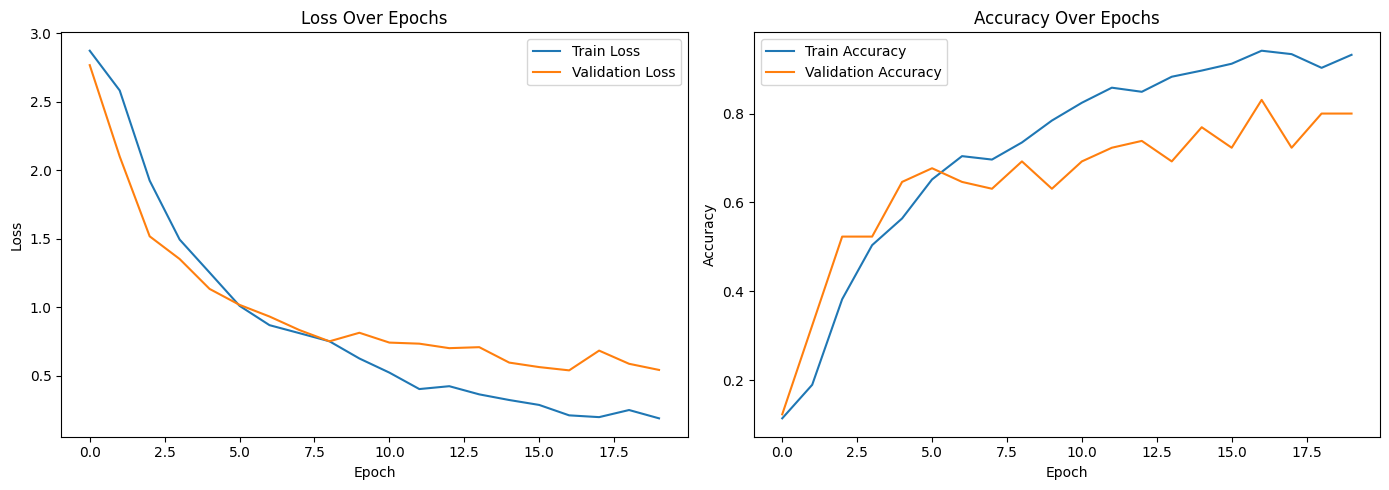

In [33]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Seems like the model is highly accurate and in not overfitting, however when we will have a look a the confusion matrix perspective will change....

[ 0  0  0  1  1  1  1  1  2  2  2  3  3  3  3  3  4  5  6  6  7  8  8  8
  8  8  8  8  8  9  9  9  9  9 10 11 11 11 12 13 14 14 14 14 14 15 15 15
 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18]
3/3 [==============================] - 3s 1s/step


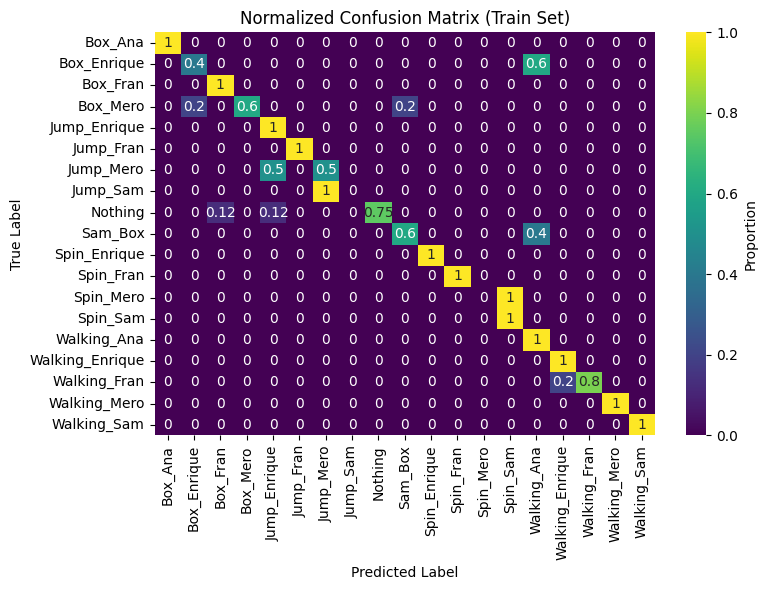

In [40]:
model = make_model()
model.load_weights('motion_classifier_model.keras')


# Get true labels and predicted labels
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

print(y_true)

# Predict probabilities
# test_generator.reset()  # Reset the generator before predicting
validation_generator.shuffle = False
validation_generator.index_array = None

y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = np.nan_to_num(cm_percent)  # Handle NaN if any class has 0 samples

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap="viridis", xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Proportion'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Train Set)")
plt.tight_layout()
plt.show()

Yes it is very uniform. This is equivalent to random guessing. The model is pretty shallow (not enough layers). I purpose to use transfer learning, features of the spectograms are hard to read both for humans and the CNN. 

We can test the model with a normal well-known model like CIFAR or MINST to see weather it will be able to learn anything. 

Note that to this file we definately need to add one-hot encoded lables - the CNNs do not undestand words.